In [1]:
import pandas as pd
import numpy as np

import math
import prophet 
import datetime as dt
from scipy.stats import boxcox
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.special import inv_boxcox
from matplotlib.ticker import StrMethodFormatter
from prophet.diagnostics import cross_validation

from prophet.diagnostics import performance_metrics

import itertools


In [120]:
"""# This file is store sessions from John Dombek for store sessions before we had 
    a GA account that would capture store sessions alone
"""
me = pd.read_csv('RawData_20221221/ME_Store_Sessions.csv')
me['Date']=pd.to_datetime(me['Date']).dt.date

""" This file is for the "promotions/or Holidays that can be taught to the model and 
used for predicting future promotions. They're almost exclusively FL because we haven't done a great job 
of tracking all promos for each brand in the past in a single place. 
Nor have the new OSD's been added to this list.
"""
holidays = pd.read_excel('Past_Future_PromosForForecasting.xlsx')



In [121]:
# import
from datetime import date


""" Here you'll 
 1. set the date to "today's system date"
 2. Format the date as a string 
 3. import a file labeled with todays date 
     3.1 that file should be the date, the store in reference (based on the glew Account IDs) and # of sessions
     3.2 IDs: 7623 = FL 
            13843 = PG
            12841 = fhf
            17404 = ME store site
            8514 = Content and store site
4. You'll get that and input and output file exists for todays date. 
5. if not create one. 
6. It'll try to read the store sessions by day file from todays input file. (you'll have to move that file there each new day you run it)


"""

# Get date
today = date.today()
# today=pd.to_datetime('2022-12-21')

# Format Date# dd/mm/YY
d1 = today.strftime("%Y/%m/%d")

# Format Date
d1= d1.replace('/','')

#Give File Name for store sessions file 
file=f'/{d1}_SessionsByGlewAccountID.csv'

# Check that folders exist and create them if not. Once created/existing read todays file into the code. 
import os
if not os.path.exists('Output/'+d1):
    os.makedirs('Output/'+d1)
if not os.path.exists('Input/'+d1):
    os.makedirs('Input/'+d1)
if os.path.exists('Input/'+d1):
    print('1')
    try:
        print('Input/'+d1+file)
        b = pd.read_csv('Input/'+d1+file)
        
        print('Sessions File Found')
    except FileNotFoundError: 
        print('Sessions file missing')
        
# b['day']=pd.to_datetime(b['day'])
d1

b

1
Input/20230414/20230414_SessionsByGlewAccountID.csv
Sessions File Found


,day,glew_account_id,sessions
0,5/23/17 0:00,7623,1436
1,5/27/17 0:00,7623,2544
2,5/28/17 0:00,7623,2827
3,5/31/17 0:00,7623,5028
4,6/1/17 0:00,7623,3705
...,...,...,...
6366,12/23/18 0:00,8514,1
6367,12/24/18 0:00,8514,1
6368,6/13/19 0:00,8514,1
6369,8/24/22 0:00,7623,26965


In [122]:
# get rid of days with 0 sessions or missing values
me.dropna(inplace=True)
# Check the maximum date in the file. 
me['Date'].max()

datetime.date(2022, 8, 28)

,Date,Sessions
0,2018-01-01,335
1,2018-01-02,473
2,2018-01-03,412
3,2018-01-04,456
4,2018-01-05,415
...,...,...
1696,2022-08-24,"7,877"
1697,2022-08-25,"8,893"
1698,2022-08-26,"6,574"
1699,2022-08-27,"5,082"


In [124]:
# Pick Which ME store to ignore 
not_me = [17404, 8514]
me_picked = not_me[0] # assing the picking
print(me_picked) # Confirm you picked right. 

other = b.copy() # Create a copy of your input dataset. 
other =other[other.glew_account_id ==me_picked] # grab only the ME store in question
other
# Set dates to date time values
other['day']= pd.to_datetime(other['day']).dt.date
# pick only the newer ME store data for dates after which the John supplied data does not exist IE new sessions
other = other[pd.to_datetime(other['day'])>pd.to_datetime(me['Date'].max())]

# Assign glew account ID to dataset 
me['id'] = me_picked
other.columns = ['Date','id','Sessions']
me = pd.concat([me,other]) # combine the john provided data with the updated export data for me sessions



b.glew_account_id.value_counts()
# Get rid of the glew account ID you do not want to use.
b = b[~b.glew_account_id.isin(not_me)]
# make sure you only have a single date value by brand for all brands
bb = b.groupby(['day','glew_account_id']).agg({
    'sessions':'sum'
})

# Reset index
bb.reset_index(inplace=True)
# Relabel columns
bb.columns = ['Date','id','Sessions']

# make the sessions value an integer
bb['Sessions'] = bb['Sessions'].astype(int)
# Combine the ME store only data with the other 3 brands data
stores = pd.concat([me,bb])

# Make sure its date time for all data
stores['Date'] = pd.to_datetime(stores["Date"]).dt.date


stores
# Convert numbers that might have comas into floats. 
stores['Sessions']=stores['Sessions'].astype(str)
stores['Sessions']=stores['Sessions'].str.replace(",",'')
stores['Sessions']=stores['Sessions'].astype(float)

# Create almost final working dataset 
sessions = stores.copy()
# rename columns 
sessions.columns = ['date','visits', 'id']

# Add ds and y columns for modeling 
sessions['ds']=sessions['date']
sessions['y']=sessions['visits']

# Assing to a dataset df to make it easy
df=sessions.copy()
# create a back up df copy incase its needed. 
d=df.copy()

17404


<ipython-input-125-25c8cd6bc1f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Lambda: 0.09648816712520411


<ipython-input-125-25c8cd6bc1f2>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['glew_account_id']=brand
<ipython-input-125-25c8cd6bc1f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Lambda: -0.062840821157777


<ipython-input-125-25c8cd6bc1f2>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['glew_account_id']=brand
<ipython-input-125-25c8cd6bc1f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Lambda: -0.048349321575427984


<ipython-input-125-25c8cd6bc1f2>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['glew_account_id']=brand
<ipython-input-125-25c8cd6bc1f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Lambda: 0.05950637644277792


<ipython-input-125-25c8cd6bc1f2>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['glew_account_id']=brand


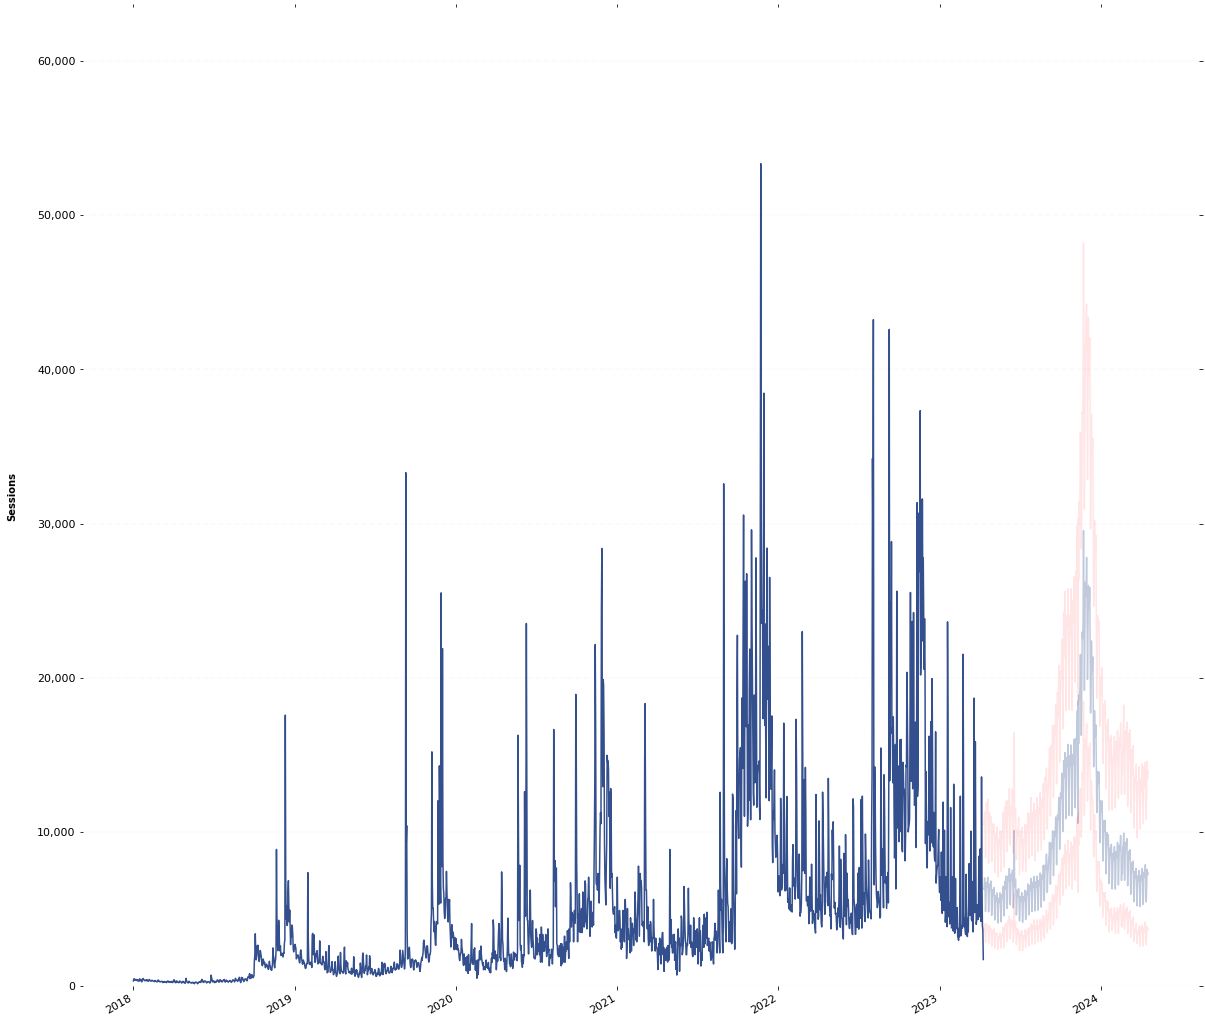

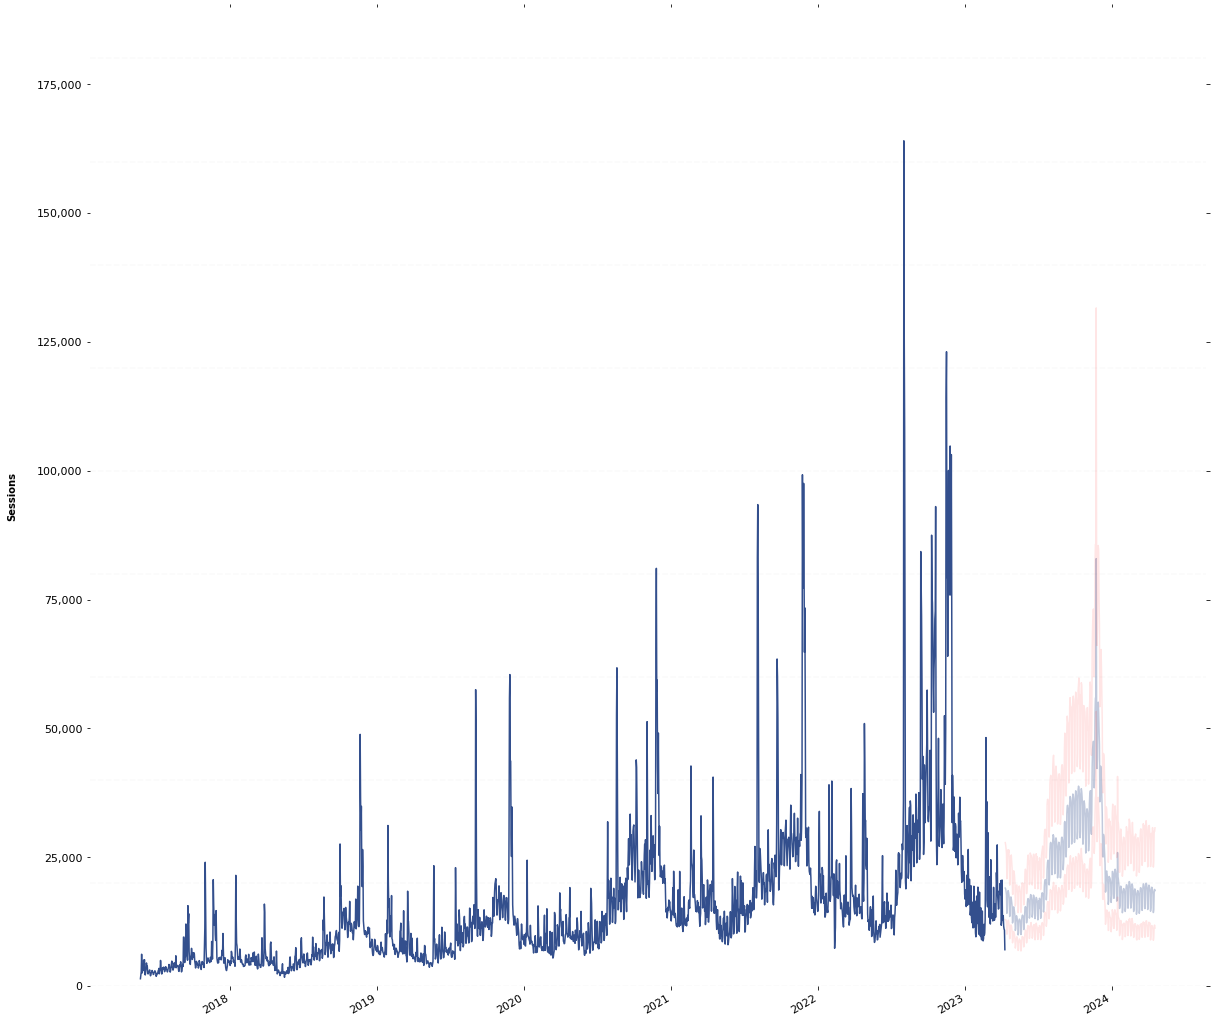

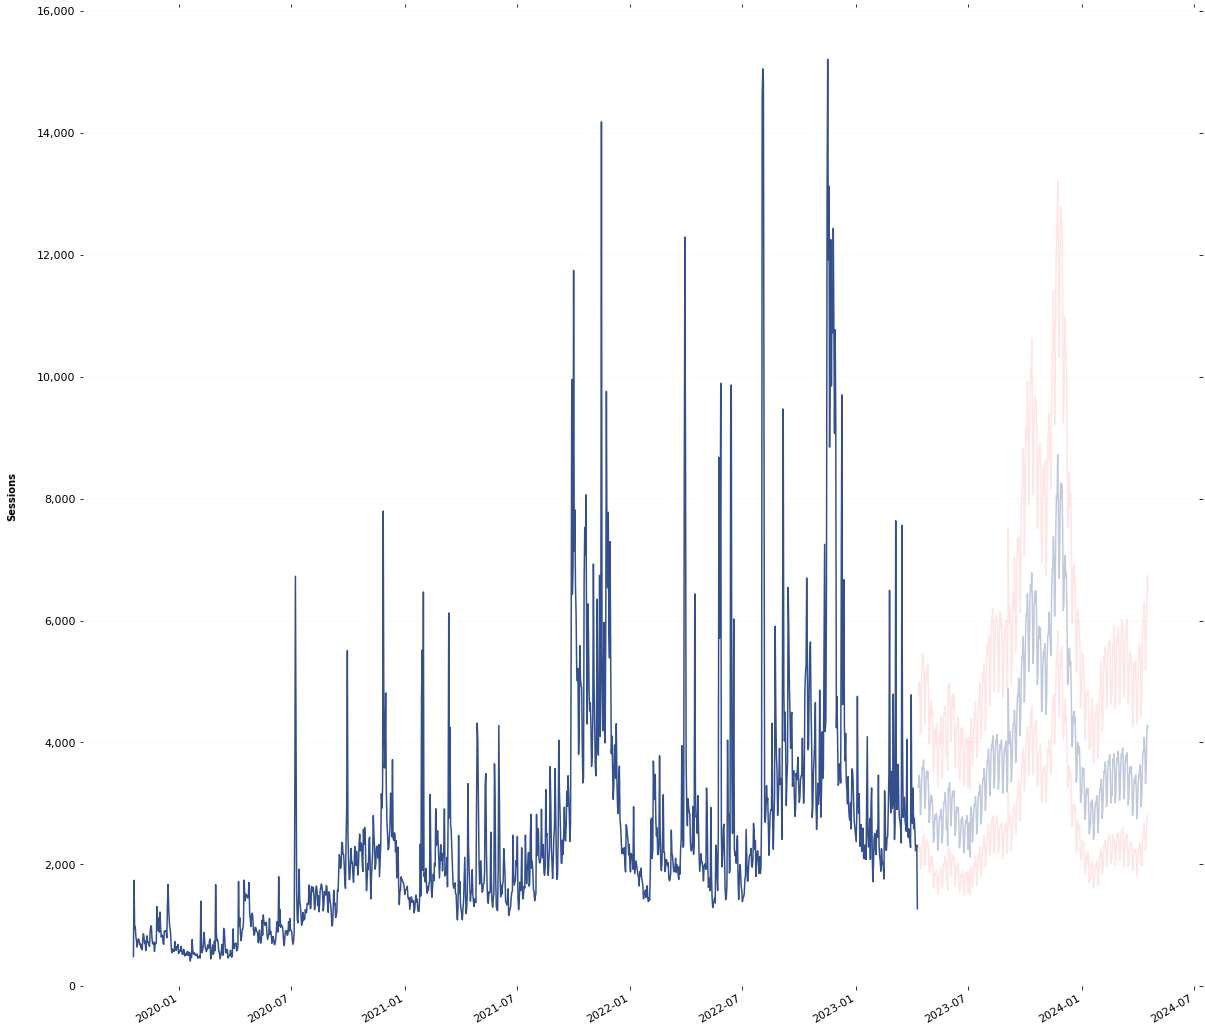

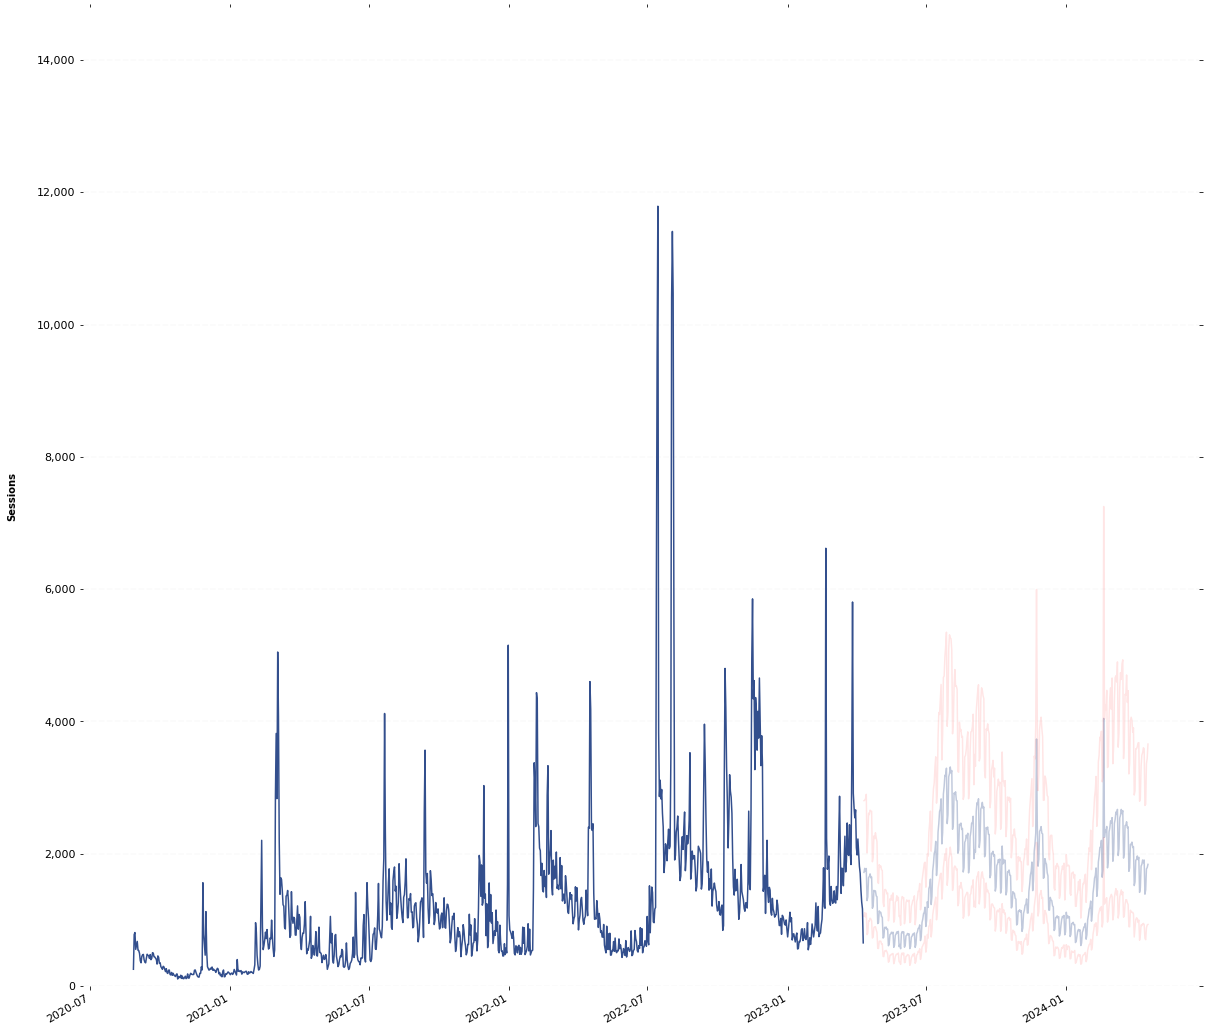

In [125]:
# Create a holding list
x=[]
# dictionary to contain the Glew account ID and brand abbreviation
bn = {17404:'ME',7623:'FL',12841:'FHF',13843:'PG'}
# Provide a value for each brand ID and its changepoint range (model parameter)
change_range = {17404:.7,
                7623:.8,
                12841:.8,
                13843:.7}
# Loop the Brand IDs and Create a model for each
for brand in [17404,7623,12841,13843]: # pick brand id

    brand_name = bn[brand] # Grab the name for naming 

    dd=[] # holding list

    df=d[d.id==brand] # get only brand specific data

    df['date'] = df['date'].astype('datetime64[ns]') # ensure data type is date time
    df =df.set_index('date') # set date index


    # Apply Box-Cox Transform to value column
    df['y'], lam = boxcox(df['visits'])
    dd.append(df) 
    # Print lambda value
    print('Lambda: {}'.format(lam))
    m = prophet.Prophet(interval_width=.8 ,
#                         holidays=holidays,  #Choose where to include holidays or not? 
#                         changepoint_prior_scale=0.075, # same change point range for all or next line
                        changepoint_range=change_range[brand]) # variable change point by brand. 

#     m = prophet.Prophet(interval_width=.8, holidays = holidays)
    #                     changepoint_prior_scale=0.075,
#                         changepoint_range=.7)
# add US Country holidays
    m.add_country_holidays(country_name='US')

    # Call fit method on Prophet object and pass in prepared dataframe. This is where model fitting is performed
    m.fit(df)

    # Create a dataframe with ds extending the chosen number of periods into the future
    future = m.make_future_dataframe(periods=373)

# Create the forecast
    forecast = m.predict(future)

# forecast.tail()






# Apply inverse Box-Cox transform to specific columns
    forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
    forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]
    forecast = forecast.set_index('ds')

    forecast.head()


#    Get the forecast data for all data past some date 
    forecast =forecast[forecast.index >= pd.to_datetime('2022-01-01')] 
#     forecast =forecast[forecast.index >= pd.to_datetime('2023-01-01')] 
    # forecast[forecast.index > df.index.max()] 
    # add columns for month and year to make grouping easier
    forecast['month'] = forecast.index.month
    forecast['year'] = forecast.index.year

    # Select only columns of interest. 
    f = forecast[['yhat_upper','yhat','yhat_lower']]
    # relable columns to be brand specific
    f.columns = [f'upper_{brand_name}',f'prediction_{brand_name}',f'lower_{brand_name}']
    # add column for labeling too.
    f['glew_account_id']=brand
    # round the dataset
    f = round(f)
    # add it to the collection list for forecasted data (Top of cell)
    x.append(f)
    
    # Create figure and subplot
    plt.figure(figsize=(20,20))
    ax = plt.subplot(111)

    # Plot
    df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)
    forecast['yhat'][forecast.index > df.index.max()].plot(color='#334f8d', alpha=0.3, fontsize=11, zorder=2, ax=ax)
    forecast['yhat_lower'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)
    forecast['yhat_upper'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)

    # Despine
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Remove x-axis label
    ax.set_xlabel('')

    # Change the facecolor
    # ax.set_facecolor('#f7f7f9')

    # Switch off ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Get y-axis tick values
    vals = ax.get_yticks()

    # Draw horizontal axis lines
    for val in vals:
        ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

    # Format y-axis label
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    # Set y-axis label
    ax.set_ylabel("Sessions", labelpad=20, weight='bold')

    # Set y-axis limit
    ylim = ax.set_ylim(bottom=0)
    # xlim = ax.set_xlim(left=pd.to_datetime('2019-01-01'))

    # save forecast as desired. 
    plt.savefig(f'Output/{d1}/{d1}_{brand_name}_forecast.png')

In [126]:

# combine the forecasts for all the brands into a single dataset 
x = pd.concat(x, axis=1)
# save it in todays output folder with todays date applied. 
x.to_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand.csv')


In [127]:
# Read the massive data set back in or select a past dataset
x = pd.read_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand.csv')
# Set index
x = x.reset_index()
# Grab just Phelps data for 2023
z = x[['ds','upper_PG','prediction_PG','lower_PG']]
z['ds'] =pd.to_datetime(z['ds']).dt.date
z['year'] =pd.to_datetime(z['ds']).dt.year
z=z[z['year']==2023]
z['ds'] =pd.to_datetime(z['ds']).dt.month

# Transform data (group by year =2023  and  month)
pd.DataFrame(z.groupby('ds').sum()).T.to_csv(f'Output/{d1}/{d1}_Updated_phelps.csv')

# Same for FHF 
z = x[['ds','upper_FHF','prediction_FHF','lower_FHF']]
z['ds'] =pd.to_datetime(z['ds']).dt.date
z['year'] =pd.to_datetime(z['ds']).dt.year
z=z[z['year']==2023]
z['ds'] =pd.to_datetime(z['ds']).dt.month

pd.DataFrame(z.groupby('ds').sum()).T.to_csv(f'Output/{d1}/{d1}_Updated_FHF.csv')


# Same for ME 

z = x[['ds','upper_ME','prediction_ME','lower_ME']]
z['ds'] =pd.to_datetime(z['ds']).dt.date
z['year'] =pd.to_datetime(z['ds']).dt.year
z=z[z['year']==2023]
z['ds'] =pd.to_datetime(z['ds']).dt.month

pd.DataFrame(z.groupby('ds').sum()).T.to_csv(f'Output/{d1}/{d1}_Updated_ME.csv')

# Same for FL
z = x[['ds','upper_FL','prediction_FL','lower_FL']]
z['ds'] =pd.to_datetime(z['ds']).dt.date
z['year'] =pd.to_datetime(z['ds']).dt.year
z=z[z['year']==2023]
z['ds'] =pd.to_datetime(z['ds']).dt.month

pd.DataFrame(z.groupby('ds').sum()).T.to_csv(f'Output/{d1}/{d1}_Updated_FL.csv')

<ipython-input-127-fdb2d6a390f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z['ds'] =pd.to_datetime(z['ds']).dt.date
<ipython-input-127-fdb2d6a390f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z['year'] =pd.to_datetime(z['ds']).dt.year
<ipython-input-127-fdb2d6a390f9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

#Base Data

In [128]:
# Get fewer values in a different format
x = pd.read_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand.csv')
x = x.reset_index()
x
y = x[['ds','prediction_ME','prediction_FL','prediction_FHF','prediction_PG']]
y['year'] = pd.to_datetime(y['ds']).dt.year
y['month'] = pd.to_datetime(y['ds']).dt.month
y=y[y['year']==2023]

yy = y.groupby('month').sum().T
yy.to_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand_monthly_Pred.csv')


x = pd.read_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand.csv')
x = x.reset_index()
x
y = x[['ds','upper_ME','upper_FL','upper_FHF','upper_PG']]
y['year'] = pd.to_datetime(y['ds']).dt.year
y['month'] = pd.to_datetime(y['ds']).dt.month
y=y[y['year']==2023]

yy = y.groupby('month').sum().T
yy.to_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand_monthly_Upper.csv')

y = x[['ds','lower_ME','lower_FL','lower_FHF','lower_PG']]
y['year'] = pd.to_datetime(y['ds']).dt.year
y['month'] = pd.to_datetime(y['ds']).dt.month
y=y[y['year']==2023]

yy = y.groupby('month').sum().T
yy.to_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand_monthly_lower.csv')



y = x[['ds','prediction_ME','prediction_FL','prediction_FHF','prediction_PG',
       'upper_ME','upper_FL','upper_FHF','upper_PG',
       'lower_ME','lower_FL','lower_FHF','lower_PG']]
y['year'] = pd.to_datetime(y['ds']).dt.year
y['month'] = pd.to_datetime(y['ds']).dt.month
y=y[y['year']==2023]

yy = y.groupby('month').sum().T
yy.to_csv(f'Output/{d1}/{d1}_ForecastasofTodayByBrand_monthly_all.csv')

<ipython-input-128-04bdf043bc04>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['year'] = pd.to_datetime(y['ds']).dt.year
<ipython-input-128-04bdf043bc04>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['month'] = pd.to_datetime(y['ds']).dt.month
<ipython-input-128-04bdf043bc04>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [118]:
df

,visits,id,ds,y
date,,,,
2021-01-01,173.0,13843,2021-01-01,6.030788
2022-01-01,1066.0,13843,2022-01-01,8.640365
2023-01-01,744.0,13843,2023-01-01,8.101618
2021-01-10,402.0,13843,2021-01-10,7.205763
2022-01-10,610.0,13843,2022-01-10,7.809032
...,...,...,...,...
2021-09-08,1292.0,13843,2021-09-08,8.933176
2022-09-08,2054.0,13843,2022-09-08,9.653098
2020-09-09,480.0,13843,2020-09-09,7.460478


# Branded

### This is basically the same as above but just does an individual brand at a time so you can visualize the results. Just make sure the parameters you set above match what they're hard coded in here 


In [110]:
me = pd.read_csv('RawData_20221221/ME_Store_Sessions.csv')
me['Date']=pd.to_datetime(me['Date']).dt.date


holidays = pd.read_excel('Past_Future_PromosForForecasting.xlsx')

from datetime import date

today = date.today()
# today=pd.to_datetime('2022-12-21')

# dd/mm/YY
d1 = today.strftime("%Y/%m/%d")
d1

d1= d1.replace('/','')


file=f'/{d1}_SessionsByGlewAccountID.csv'


import os
if not os.path.exists('Output/'+d1):
    os.makedirs('Output/'+d1)

if not os.path.exists('Input/'+d1):
    os.makedirs('Input/'+d1)
    
if os.path.exists('Input/'+d1):
    print('1')
    try:
        print('Input/'+d1+file)
        b = pd.read_csv('Input/'+d1+file)
        
        print('Sessions File Found')
    except FileNotFoundError: 
        print('Sessions file missing')
        
# b['day']=pd.to_datetime(b['day'])
d1

b
# Pick Which ME store to ignore 
me.dropna(inplace=True)

not_me = [17404, 8514]
me_picked = not_me[0]
print(me_picked)

other = b.copy()
other =other[other.glew_account_id ==me_picked]
other
other['day']= pd.to_datetime(other['day']).dt.date
other = other[pd.to_datetime(other['day'])>pd.to_datetime(me['Date'].max())]

me['id'] = me_picked
other.columns = ['Date','id','Sessions']
me = pd.concat([me,other])



b.glew_account_id.value_counts()
b = b[~b.glew_account_id.isin(not_me)]
bb = b.groupby(['day','glew_account_id']).agg({
    'sessions':'sum'
})


bb.reset_index(inplace=True)
bb.columns = ['Date','id','Sessions']

bb['Sessions'] = bb['Sessions'].astype(int)
stores = pd.concat([me,bb])

stores['Date'] = pd.to_datetime(stores["Date"]).dt.date

stores
stores['Sessions']=stores['Sessions'].astype(str)
stores['Sessions']=stores['Sessions'].str.replace(",",'')
stores['Sessions']=stores['Sessions'].astype(float)


sessions = stores.copy()
sessions.columns = ['date','visits', 'id']

sessions['ds']=sessions['date']
sessions['y']=sessions['visits']

df=sessions.copy()

d=df.copy()
d

1
Input/20230413/20230413_SessionsByGlewAccountID.csv
Sessions File Found
17404


,date,visits,id,ds,y
0,2018-01-01,335.0,17404,2018-01-01,335.0
1,2018-01-02,473.0,17404,2018-01-02,473.0
2,2018-01-03,412.0,17404,2018-01-03,412.0
3,2018-01-04,456.0,17404,2018-01-04,456.0
4,2018-01-05,415.0,17404,2018-01-05,415.0
...,...,...,...,...,...
4369,2021-09-09,2868.0,12841,2021-09-09,2868.0
4370,2021-09-09,1335.0,13843,2021-09-09,1335.0
4371,2022-09-09,36356.0,7623,2022-09-09,36356.0
4372,2022-09-09,3870.0,12841,2022-09-09,3870.0


In [111]:
me

,Date,Sessions,id
0,2018-01-01,335,17404
1,2018-01-02,473,17404
2,2018-01-03,412,17404
3,2018-01-04,456,17404
4,2018-01-05,415,17404
...,...,...,...
5788,2023-03-23,15847,17404
5790,2023-03-24,8174,17404
5793,2023-03-26,4245,17404
5798,2023-04-01,4790,17404


# ME




<ipython-input-112-7a2890416608>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
<ipython-input-112-7a2890416608>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds']=df['date'].copy()
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1926 entries, 2018-01-01 to 2023-04-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   visits  1926 non-null   float64       
 1   id      1926 non-null   int64         
 2   ds      1926 non-null   datetime64[ns]
 3   y       1926 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 75.2 KB
Lambda: 0.09648816712520411


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2381,2024-07-09,14.708825,12.113680,15.328615,13.595037,15.789386,0.0,0.0,0.0,0.0,...,0.087816,0.087816,0.087816,-1.082708,-1.082708,-1.082708,0.0,0.0,0.0,13.713933
2382,2024-07-10,14.709598,12.166474,15.305914,13.592814,15.793725,0.0,0.0,0.0,0.0,...,0.121735,0.121735,0.121735,-1.071968,-1.071968,-1.071968,0.0,0.0,0.0,13.759365
2383,2024-07-11,14.710370,12.365954,15.586312,13.590673,15.797352,0.0,0.0,0.0,0.0,...,0.321919,0.321919,0.321919,-1.058677,-1.058677,-1.058677,0.0,0.0,0.0,13.973612
2384,2024-07-12,14.711143,12.049058,15.274642,13.588531,15.800789,0.0,0.0,0.0,0.0,...,0.006447,0.006447,0.006447,-1.043152,-1.043152,-1.043152,0.0,0.0,0.0,13.674438
2385,2024-07-13,14.711916,11.588768,14.809403,13.586389,15.804226,0.0,0.0,0.0,0.0,...,-0.547220,-0.547220,-0.547220,-1.025734,-1.025734,-1.025734,0.0,0.0,0.0,13.138962


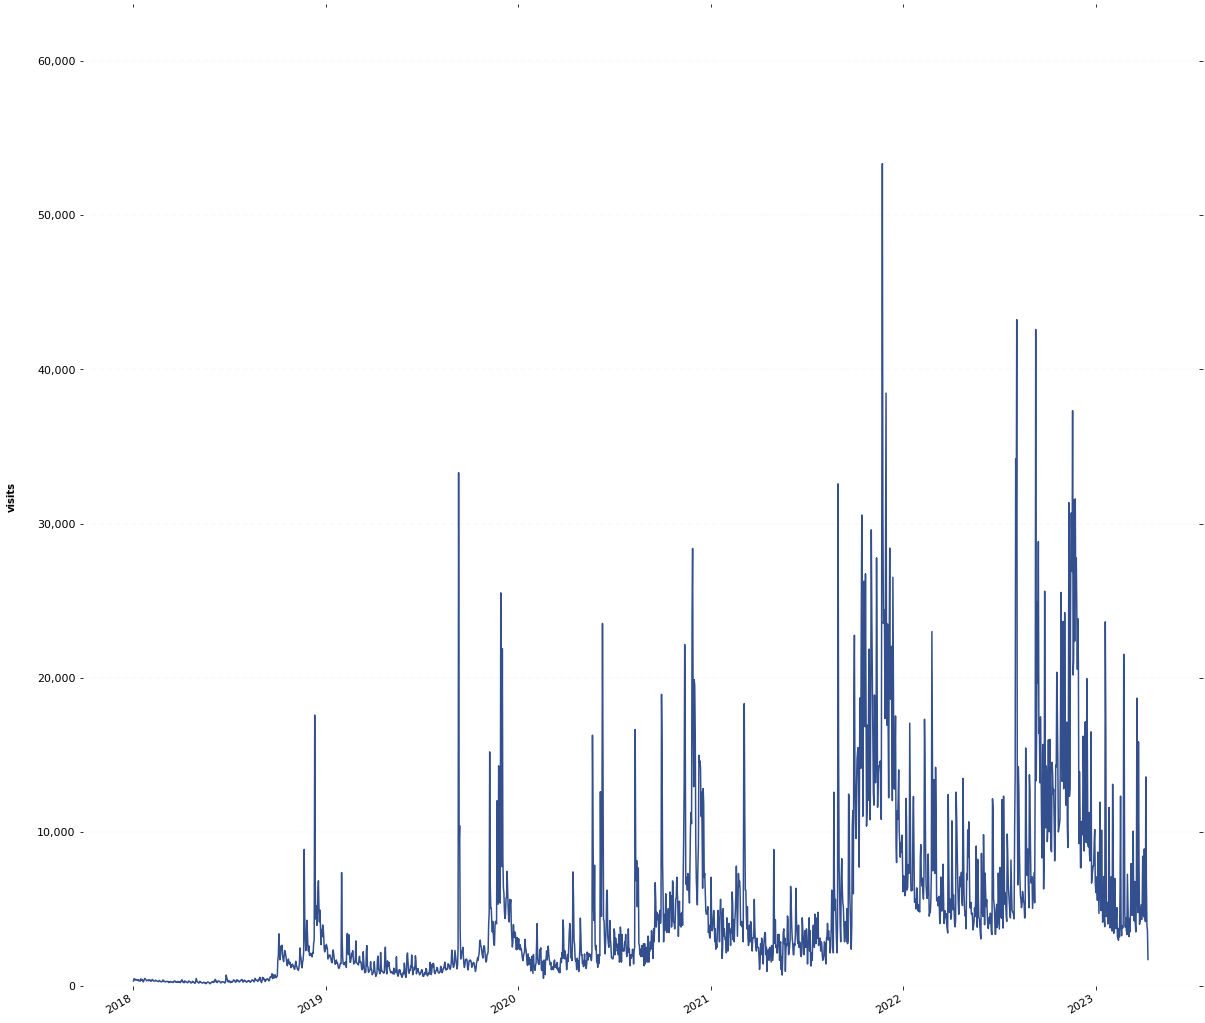

In [112]:
dd=[]

# b.columns = ['date','id','visits']
df=d[d.id==17404]


df['date'] = df['date'].astype('datetime64[ns]')
df['ds']=df['date'].copy()

df =df.set_index('date')
df.info()

# Apply Box-Cox Transform to value column
df['y'], lam = boxcox(df['visits'])
dd.append(df)
# Print lambda value
print('Lambda: {}'.format(lam))
# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# Remove x-axis label
ax.set_xlabel('')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Annotate
# x_line_annotation = dt.datetime(2017, 5, 1) 
# x_text_annotation = dt.datetime(2017, 5, 5)
# ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
# ax.text(x=x_text_annotation, y=670000, s='Trend Changepoint', alpha=0.7, color='#334f8d')

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("visits", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0)

df=pd.concat(dd)



# Instantiate Prophet object
# m = fbprophet.Prophet(interval_width=.95)
m = prophet.Prophet(interval_width=.75 ,
#                         holidays=holidays,
#                         changepoint_prior_scale=0.075,
                        changepoint_range=.7)

m.add_country_holidays(country_name='US')

# Call fit method on Prophet object and pass in prepared dataframe. This is where model fitting is performed
m.fit(df)

# Create a dataframe with ds extending the chosen number of periods into the future
future = m.make_future_dataframe(periods=460)

# Create the forecast
forecast = m.predict(future)

forecast.tail()

    

<ipython-input-113-88c07258c85c>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])


,yhat,yhat_lower,yhat_upper
ds,,,
2018-01-01,458.438192,239.041398,854.180417
2018-01-02,424.193831,228.344724,775.828748
2018-01-03,422.478212,214.909454,790.954830
2018-01-04,462.000700,234.246064,847.940973
2018-01-05,379.341959,199.501785,688.458755


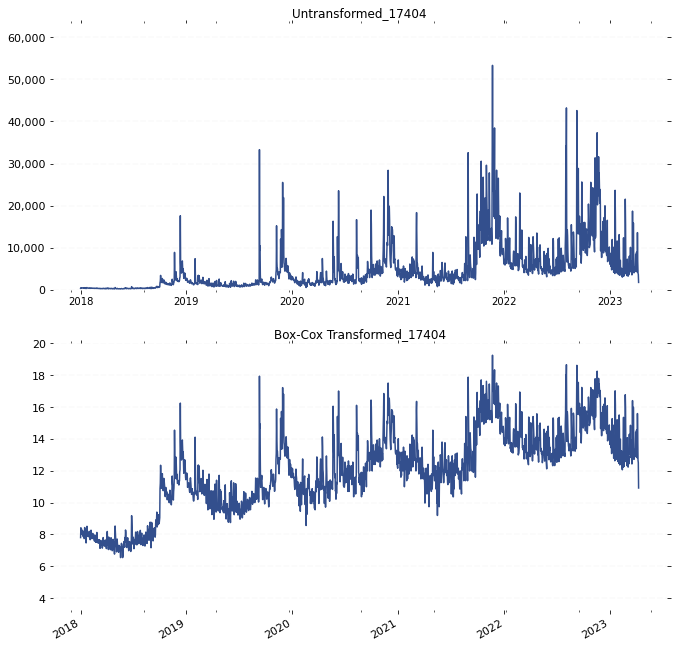

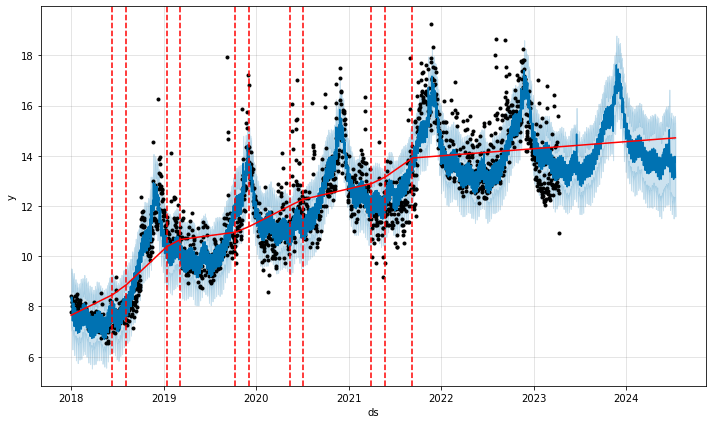

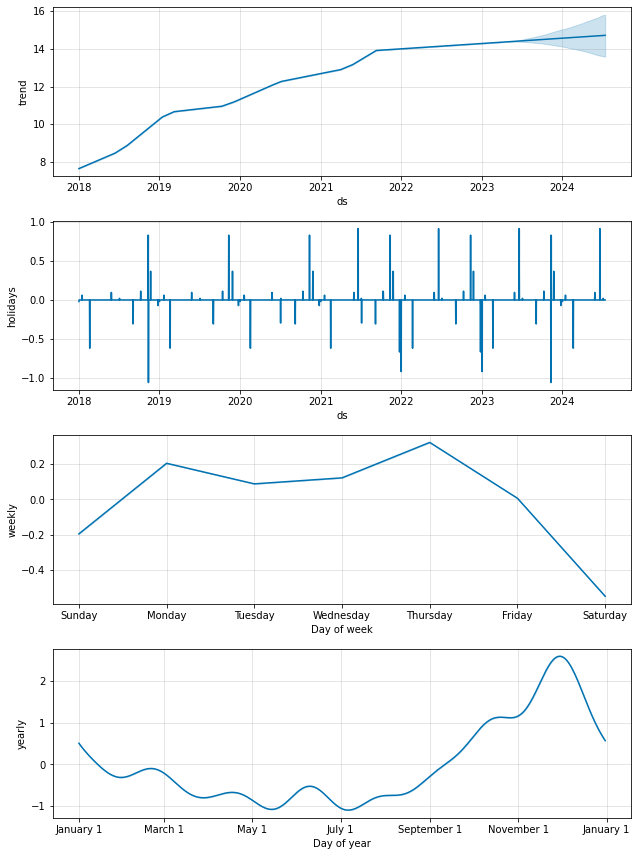

In [113]:


ax = df[['visits','y']].plot(color='#334f8d', subplots=True,
                                     sharex=True, fontsize=11, 
                                     legend=False, figsize=(11,12),
                                     title=[f'Untransformed_{17404}',f'Box-Cox Transformed_{17404}'])

for i, x in enumerate(ax):
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.spines['bottom'].set_visible(False)

    # Remove x-axis label
    x.set_xlabel('')

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Format y-axis ticks
    vals = x.get_yticks()
    x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])

    # Draw horizontal axis lines
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    # Set y-axis limit
    if i == 0:
        x.set_ylim(bottom=0)
        
        

# m.plot(forecast);
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
m.plot_components(forecast);



# Apply inverse Box-Cox transform to specific columns
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]
forecast = forecast.set_index('ds')

forecast.head()

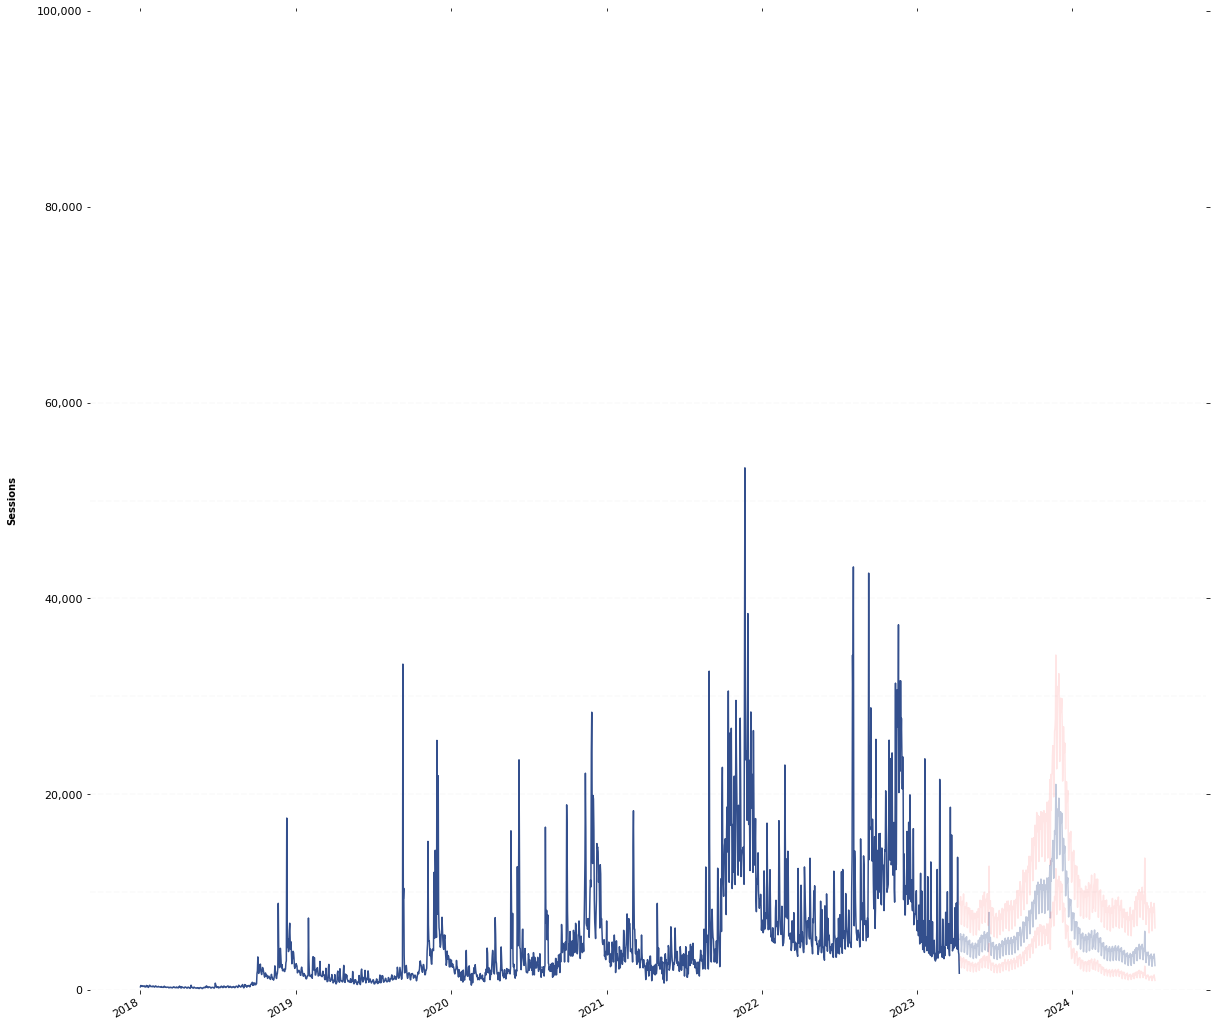

In [77]:

# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)
forecast['yhat'][forecast.index > df.index.max()].plot(color='#334f8d', alpha=0.3, fontsize=11, zorder=2, ax=ax)
forecast['yhat_lower'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)
forecast['yhat_upper'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis label
ax.set_xlabel('')

# Change the facecolor
# ax.set_facecolor('#f7f7f9')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("Sessions", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0, top = 100000)
# xlim = ax.set_xlim(left=pd.to_datetime('2019-01-01'))

In [78]:
forecast[forecast.index > pd.to_datetime('2022-10-31')] 
# forecast[forecast.index > df.index.max()] 
forecast['month'] = forecast.index.month
forecast['year'] = forecast.index.year
f = forecast.groupby(by=['year','month']).sum().tail(27)
f.reset_index(inplace=True)
f = f[f['year']>=2023]
f=f.T
f= f.reindex(["year", "month", "yhat_upper",'yhat','yhat_lower'])
# f.to_csv('20221103_ForecastV2_MEStore.csv')
# f[f['month']]
f
# f['store'] =17404
# total.append(f)
# f = forecast[forecast.year==2022]
# # forecast.iloc[:30,:]
# f =f[f.month == 11]
# pd.set_option('display.max_columns', None)
# f.T
# f2 = forecast[forecast.year==2022]
# f2 =f2[f2.month>=11]
# f2.groupby(by='month')[['yhat_upper','yhat','yhat_lower']].sum().T

,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
year,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000
month,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
yhat_upper,371568.606642,304329.867202,283972.258672,246754.892494,231588.819362,251944.042297,225627.912608,262133.498580,339732.477019,496001.787421,688139.206191,649015.169574,332542.033814,285384.244767,257999.981658,241747.122788,231313.508912,263394.983262,101918.779717
yhat,224557.594248,182996.783807,170088.130309,146515.171148,136539.333500,149955.383846,132717.453373,154072.394775,200824.880032,298427.900175,412107.723918,378695.828514,181983.486200,150447.584111,130748.264621,116479.914080,107201.572982,115673.717532,41863.976536
yhat_lower,132735.936213,108462.265182,99001.301473,85270.991957,79088.782356,87024.264446,75558.792777,88015.614923,115791.715834,174774.748627,242440.135555,215373.597617,96688.591434,77231.642317,63235.624362,53695.682916,46126.411155,47718.218839,16577.692652


In [70]:
d


,date,visits,id,ds,y
0,2018-01-01,335.0,17404,2018-01-01,335.0
1,2018-01-02,473.0,17404,2018-01-02,473.0
2,2018-01-03,412.0,17404,2018-01-03,412.0
3,2018-01-04,456.0,17404,2018-01-04,456.0
4,2018-01-05,415.0,17404,2018-01-05,415.0
...,...,...,...,...,...
4369,2021-09-09,2868.0,12841,2021-09-09,2868.0
4370,2021-09-09,1335.0,13843,2021-09-09,1335.0
4371,2022-09-09,36356.0,7623,2022-09-09,36356.0
4372,2022-09-09,3870.0,12841,2022-09-09,3870.0


# FL


<ipython-input-79-1cf8779bd3ab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2148 entries, 2018-01-01 to 2022-09-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   visits  2148 non-null   float64
 1   id      2148 non-null   int64  
 2   ds      2148 non-null   object 
 3   y       2148 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 83.9+ KB
Lambda: -0.062840821157777


<ipython-input-79-1cf8779bd3ab>:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])


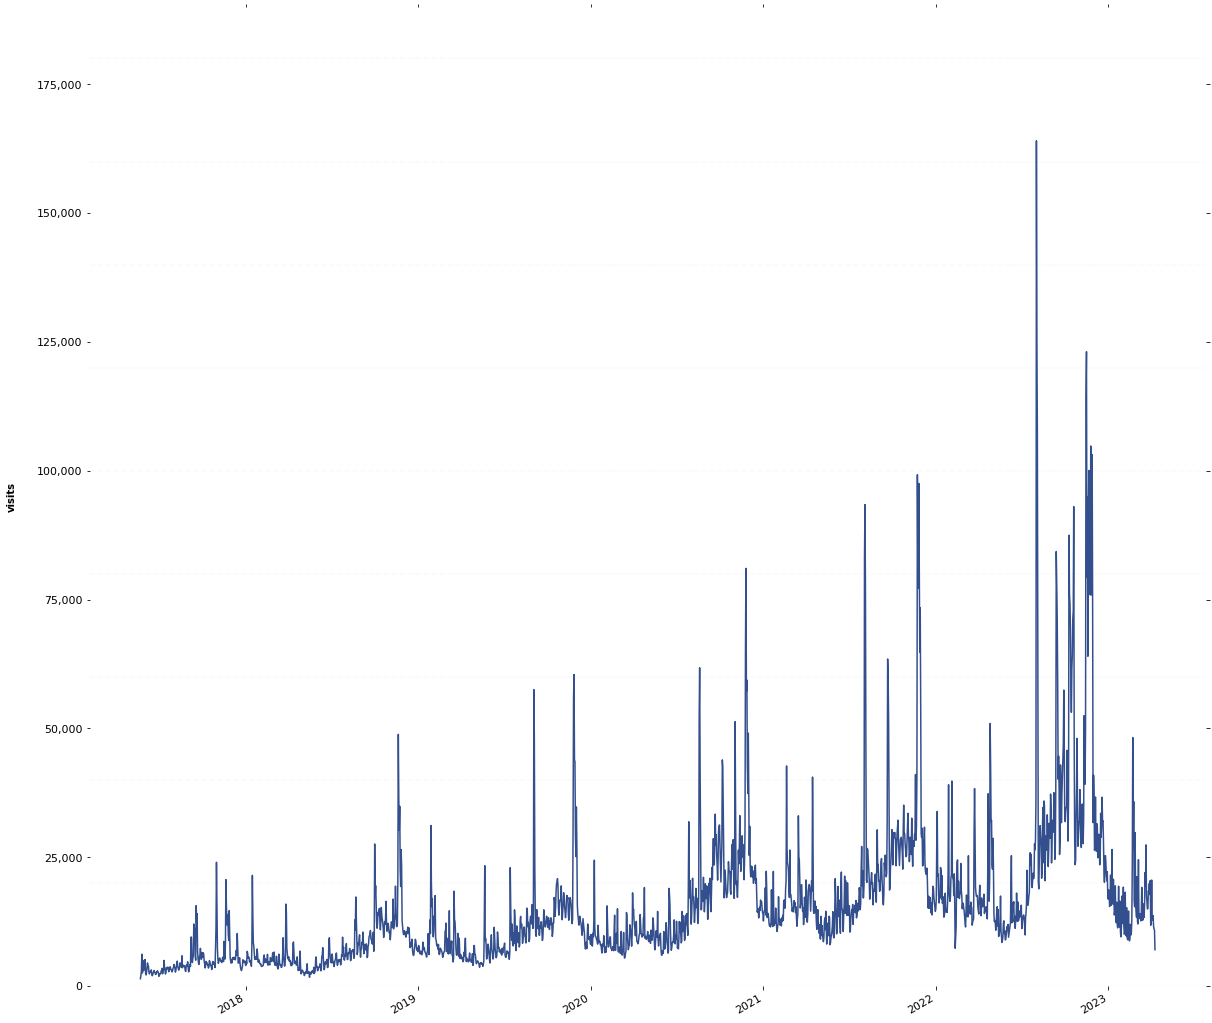

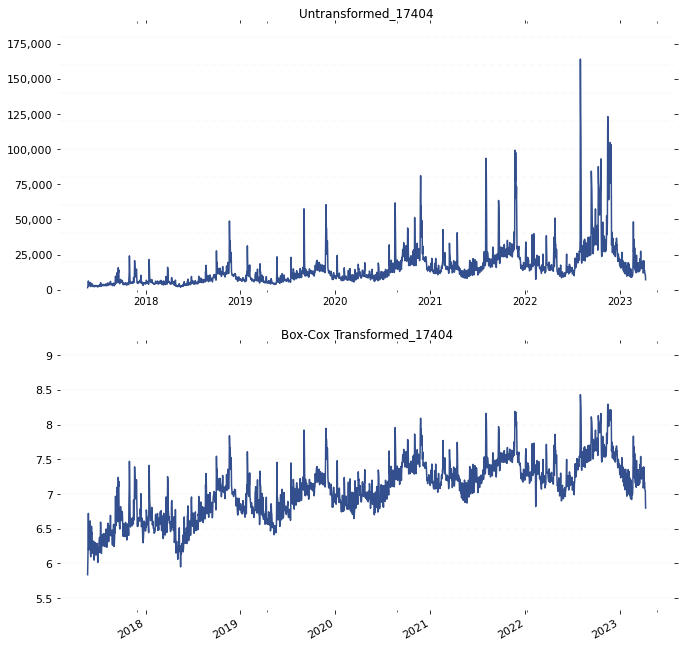

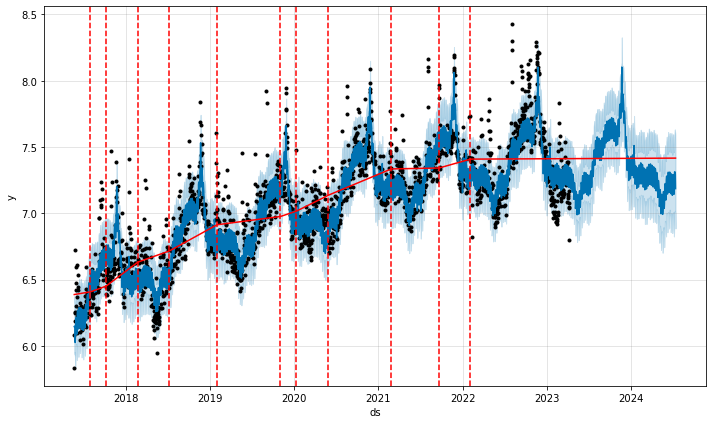

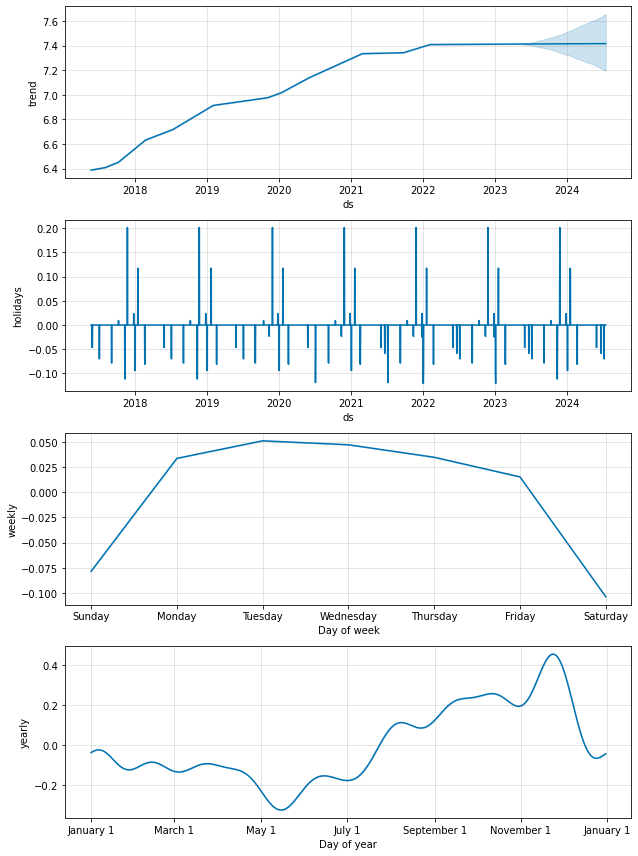

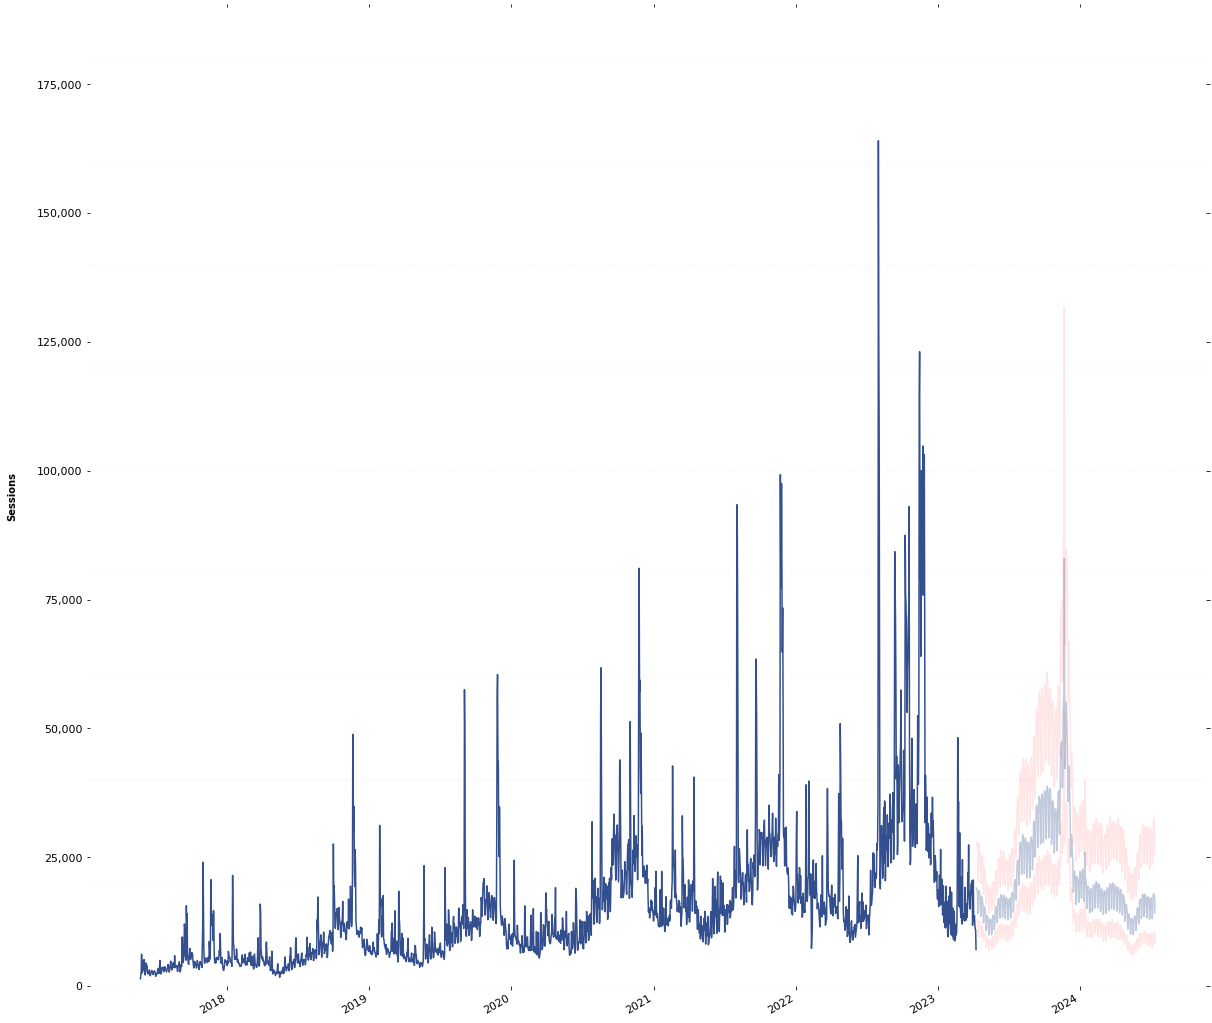

In [79]:
dd=[]

df=d[d.id==7623]

df['date'] = df['date'].astype('datetime64[ns]')
df =df.set_index('date')
df.info()


# Apply Box-Cox Transform to value column
df['y'], lam = boxcox(df['visits'])
dd.append(df)
# Print lambda value
print('Lambda: {}'.format(lam))
# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# Remove x-axis label
ax.set_xlabel('')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Annotate
# x_line_annotation = dt.datetime(2017, 5, 1) 
# x_text_annotation = dt.datetime(2017, 5, 5)
# ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
# ax.text(x=x_text_annotation, y=670000, s='Trend Changepoint', alpha=0.7, color='#334f8d')

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("visits", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0)

df=pd.concat(dd)



# Instantiate Prophet object
# m = fbprophet.Prophet(interval_width=.95)
m = prophet.Prophet(interval_width=.8 ,
#                         holidays=holidays,
#                         changepoint_prior_scale=0.075,
                        changepoint_range=.8)

m.add_country_holidays(country_name='US')

# Call fit method on Prophet object and pass in prepared dataframe. This is where model fitting is performed
m.fit(df)

# Create a dataframe with ds extending the chosen number of periods into the future
future = m.make_future_dataframe(periods=460)

# Create the forecast
forecast = m.predict(future)

forecast.tail()



ax = df[['visits','y']].plot(color='#334f8d', subplots=True,
                                     sharex=True, fontsize=11, 
                                     legend=False, figsize=(11,12),
                                     title=[f'Untransformed_{17404}',f'Box-Cox Transformed_{17404}'])

for i, x in enumerate(ax):
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.spines['bottom'].set_visible(False)

    # Remove x-axis label
    x.set_xlabel('')

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Format y-axis ticks
    vals = x.get_yticks()
    x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])

    # Draw horizontal axis lines
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    # Set y-axis limit
    if i == 0:
        x.set_ylim(bottom=0)
        
        

# m.plot(forecast);
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
m.plot_components(forecast);



# Apply inverse Box-Cox transform to specific columns
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]
forecast = forecast.set_index('ds')

forecast.head()

    

# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)
forecast['yhat'][forecast.index > df.index.max()].plot(color='#334f8d', alpha=0.3, fontsize=11, zorder=2, ax=ax)
forecast['yhat_lower'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)
forecast['yhat_upper'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis label
ax.set_xlabel('')

# Change the facecolor
# ax.set_facecolor('#f7f7f9')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("Sessions", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0)
# xlim = ax.set_xlim(left=pd.to_datetime('2019-01-01'))

In [80]:
forecast[forecast.index > pd.to_datetime('2022-10-31')] 
# forecast[forecast.index > df.index.max()] 
forecast['month'] = forecast.index.month
forecast['year'] = forecast.index.year
f = forecast.groupby(by=['year','month']).sum().tail(27)
f.reset_index(inplace=True)
f = f[f['year']>=2023]
f=f.T
f= f.reindex(["year", "month", "yhat_upper",'yhat','yhat_lower'])
# f.to_csv('20221103_ForecastV2_FLStore.csv')
# f[f['month']]
f['store'] =7623
# total.append(f)
f
# f = forecast[forecast.year==2022]
# # forecast.iloc[:30,:]
# f =f[f.month == 11]
# pd.set_option('display.max_columns', None)
# f.T
# f2 = forecast[forecast.year==2022]
# f2 =f2[f2.month>=11]
# f2.groupby(by='month')[['yhat_upper','yhat','yhat_lower']].sum().T

,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,store
year,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2.023000e+03,2.023000e+03,2.023000e+03,2.023000e+03,2.023000e+03,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,7623
month,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000e+00,9.000000e+00,1.000000e+01,1.100000e+01,1.200000e+01,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,7623
yhat_upper,869206.236082,731786.878443,805099.820637,733089.399369,580786.351825,689355.491746,850212.728846,1.221266e+06,1.439798e+06,1.605786e+06,2.029150e+06,1.259679e+06,936159.893994,825579.042603,876983.232966,840743.373463,673704.074456,823443.402289,377416.500839,7623
yhat,588056.073684,498784.080505,548491.493565,499900.856547,400223.684694,474105.020781,576384.974959,8.169817e+05,9.507431e+05,1.055997e+06,1.307352e+06,8.118479e+05,600113.571559,519769.042677,544104.552363,507929.516369,401554.605243,471517.166965,210992.531345,7623
yhat_lower,402704.813156,344136.176676,379127.540168,343540.600227,277389.737615,325484.113028,396240.212774,5.539519e+05,6.405104e+05,7.041044e+05,8.576177e+05,5.336059e+05,393686.552656,337663.739167,344417.373601,316023.315904,244727.763954,279679.773749,123062.498938,7623


# FHF

<ipython-input-81-0faf5def2caa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1269 entries, 2020-01-01 to 2022-09-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   visits  1269 non-null   float64
 1   id      1269 non-null   int64  
 2   ds      1269 non-null   object 
 3   y       1269 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 49.6+ KB
Lambda: -0.048349321575427984


<ipython-input-81-0faf5def2caa>:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])


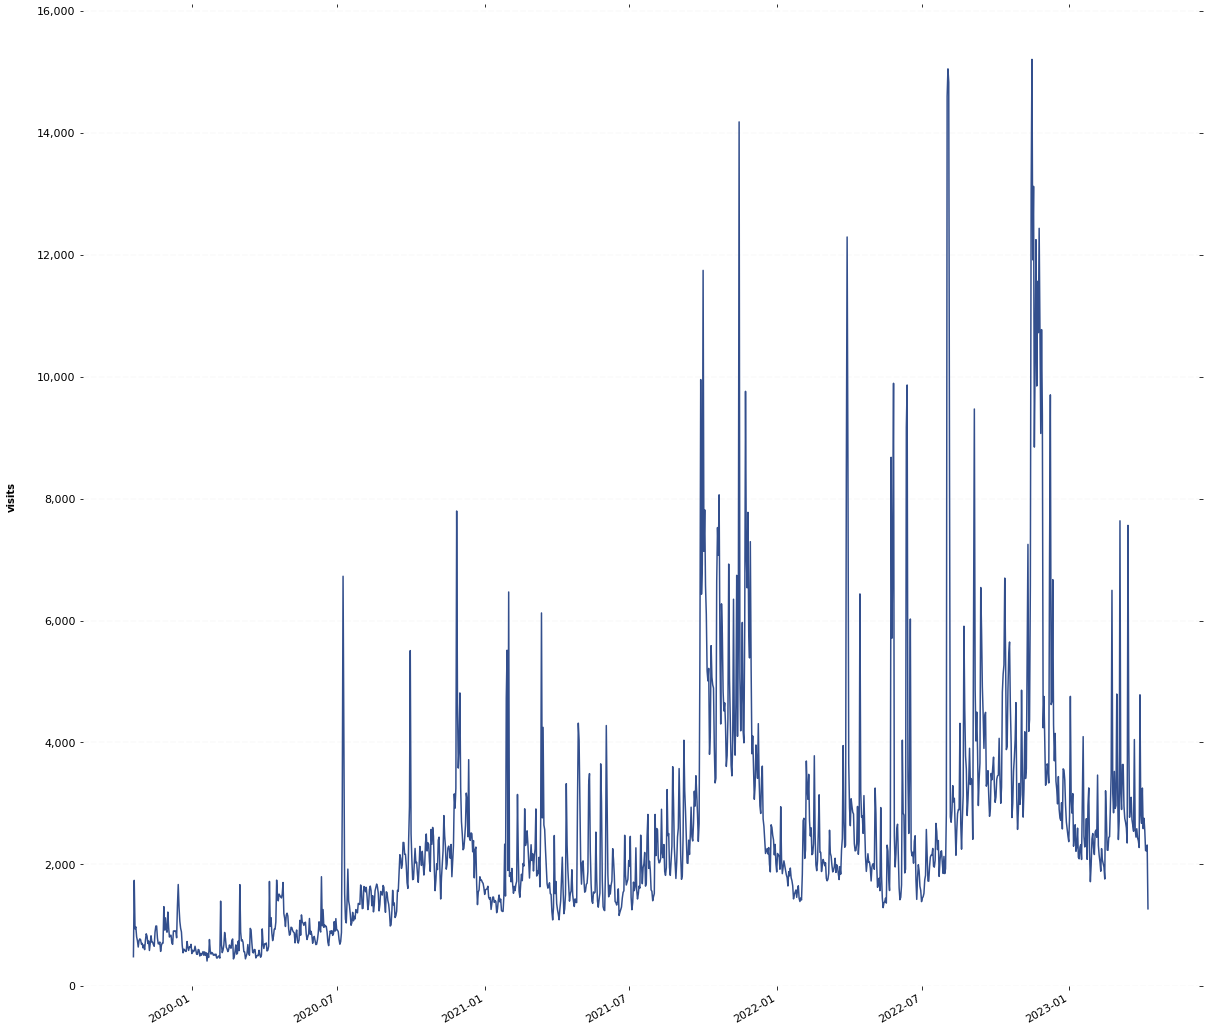

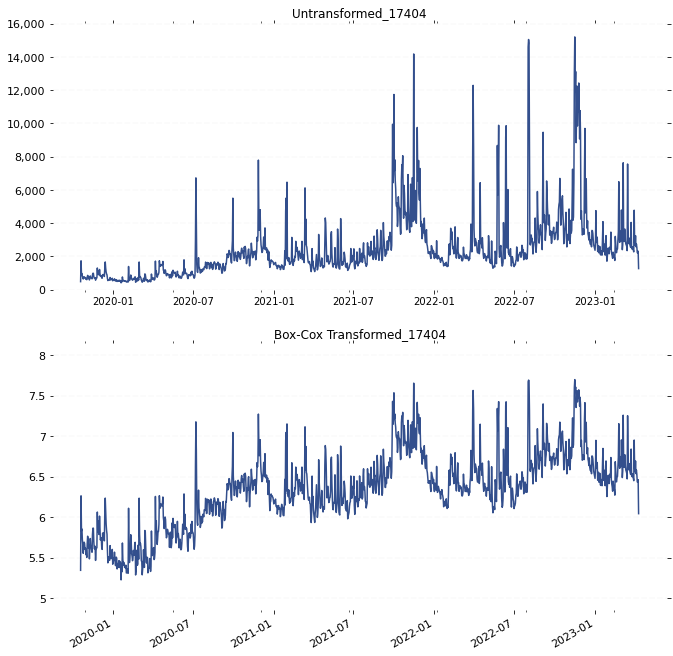

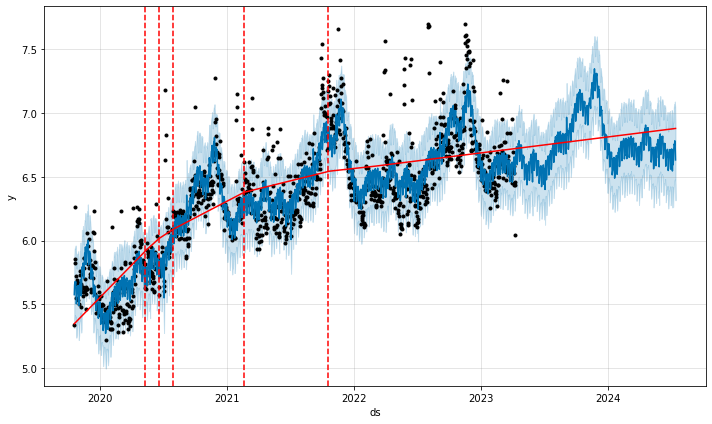

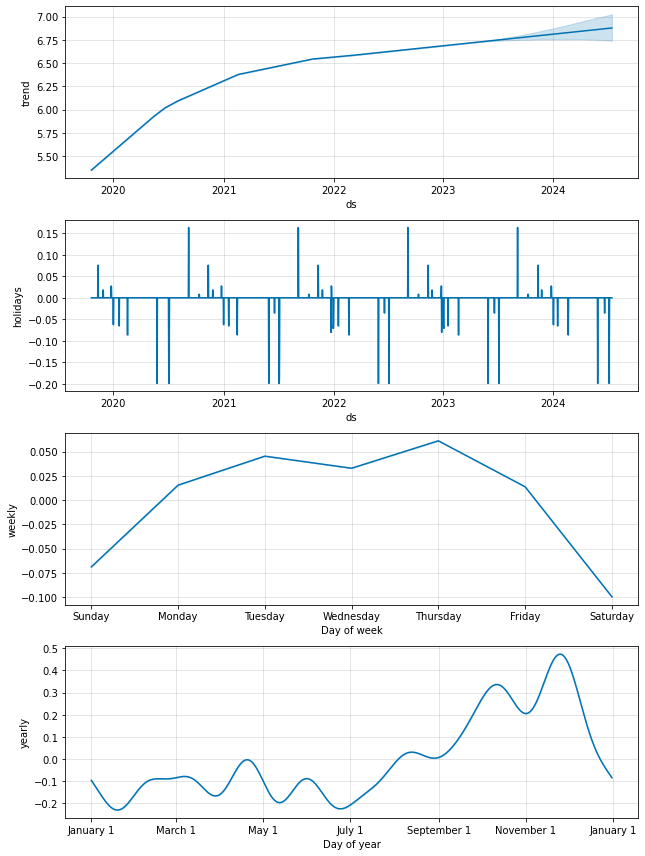

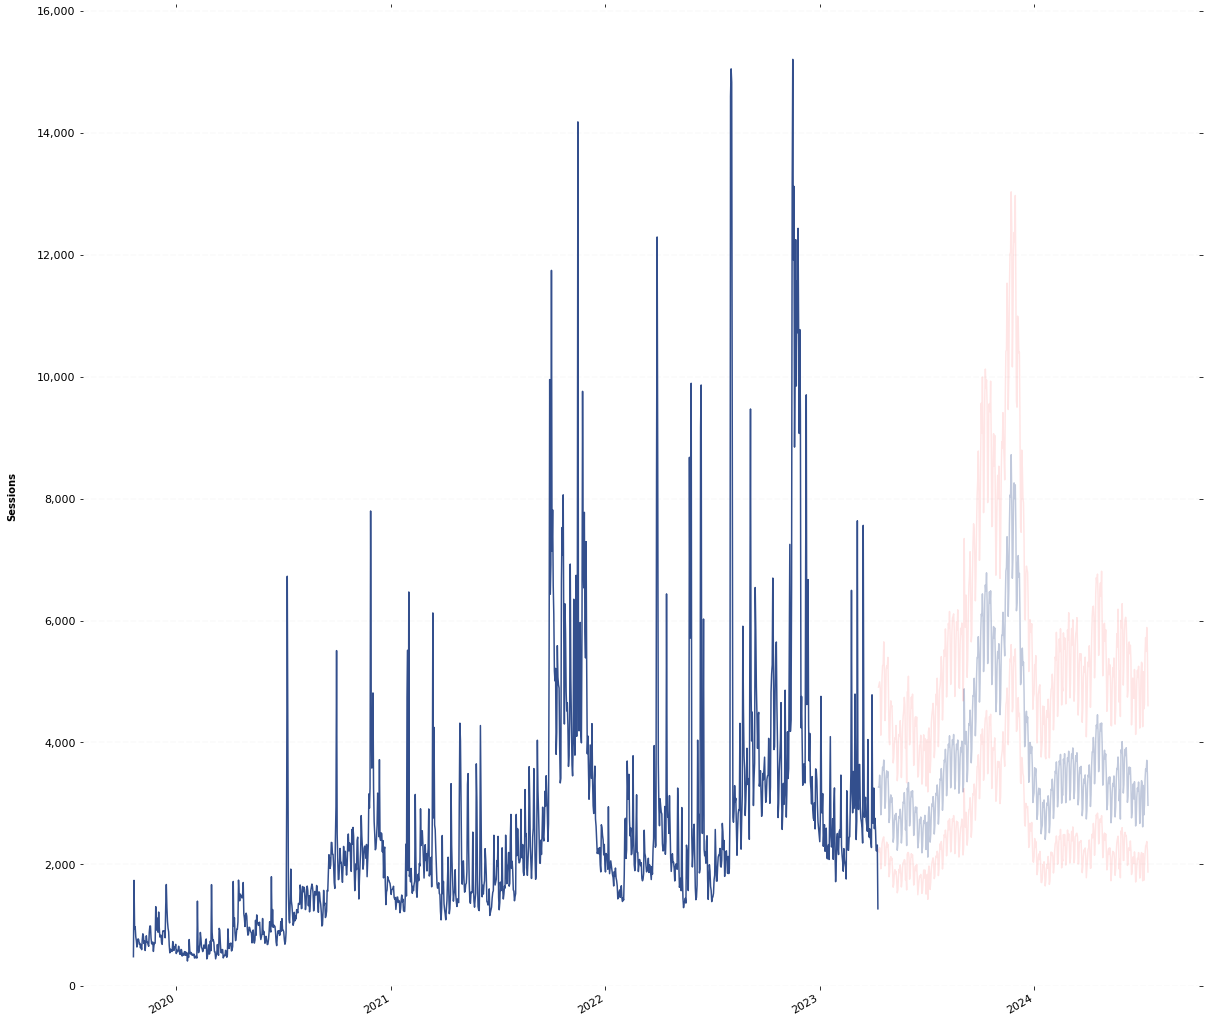

In [81]:
dd=[]

df=d[d.id==12841]

df['date'] = df['date'].astype('datetime64[ns]')
df =df.set_index('date')
df.info()


# Apply Box-Cox Transform to value column
df['y'], lam = boxcox(df['visits'])
dd.append(df)
# Print lambda value
print('Lambda: {}'.format(lam))
# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# Remove x-axis label
ax.set_xlabel('')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Annotate
# x_line_annotation = dt.datetime(2017, 5, 1) 
# x_text_annotation = dt.datetime(2017, 5, 5)
# ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
# ax.text(x=x_text_annotation, y=670000, s='Trend Changepoint', alpha=0.7, color='#334f8d')

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("visits", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0)

df=pd.concat(dd)



# Instantiate Prophet object
# m = fbprophet.Prophet(interval_width=.95)
m = prophet.Prophet(interval_width=.8 ,
#                         holidays=holidays,
#                         changepoint_prior_scale=0.075,
                        changepoint_range=.8)

m.add_country_holidays(country_name='US')

# Call fit method on Prophet object and pass in prepared dataframe. This is where model fitting is performed
m.fit(df)

# Create a dataframe with ds extending the chosen number of periods into the future
future = m.make_future_dataframe(periods=460)

# Create the forecast
forecast = m.predict(future)

forecast.tail()



ax = df[['visits','y']].plot(color='#334f8d', subplots=True,
                                     sharex=True, fontsize=11, 
                                     legend=False, figsize=(11,12),
                                     title=[f'Untransformed_{17404}',f'Box-Cox Transformed_{17404}'])

for i, x in enumerate(ax):
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.spines['bottom'].set_visible(False)

    # Remove x-axis label
    x.set_xlabel('')

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Format y-axis ticks
    vals = x.get_yticks()
    x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])

    # Draw horizontal axis lines
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    # Set y-axis limit
    if i == 0:
        x.set_ylim(bottom=0)
        
        

# m.plot(forecast);
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
m.plot_components(forecast);



# Apply inverse Box-Cox transform to specific columns
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]
forecast = forecast.set_index('ds')

forecast.head()

    

# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)
forecast['yhat'][forecast.index > df.index.max()].plot(color='#334f8d', alpha=0.3, fontsize=11, zorder=2, ax=ax)
forecast['yhat_lower'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)
forecast['yhat_upper'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis label
ax.set_xlabel('')

# Change the facecolor
# ax.set_facecolor('#f7f7f9')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("Sessions", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0)
# xlim = ax.set_xlim(left=pd.to_datetime('2019-01-01'))

In [83]:
forecast[forecast.index > pd.to_datetime('2022-10-31')] 
# forecast[forecast.index > df.index.max()] 
forecast['month'] = forecast.index.month
forecast['year'] = forecast.index.year
f = forecast.groupby(by=['year','month']).sum().tail(27)
f.reset_index(inplace=True)
f = f[f['year']>=2023]
f=f.T
f= f.reindex(["year", "month", "yhat_upper",'yhat','yhat_lower'])
# f.to_csv('20221103_ForecastV2_FHFStore.csv')
# f[f['month']]
f['store'] =12841
# f = forecast[forecast.year==2022]
# # forecast.iloc[:30,:]
# f =f[f.month == 11]
# pd.set_option('display.max_columns', None)
# f.T
# f2 = forecast[forecast.year==2022]
# f2 =f2[f2.month>=11]
# f2.groupby(by='month')[['yhat_upper','yhat','yhat_lower']].sum().T

# PG


<ipython-input-92-3afbb5691a92>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype('datetime64[ns]')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 957 entries, 2021-01-01 to 2022-09-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   visits  957 non-null    float64
 1   id      957 non-null    int64  
 2   ds      957 non-null    object 
 3   y       957 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 37.4+ KB
Lambda: 0.05950637644277792


<ipython-input-92-3afbb5691a92>:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])


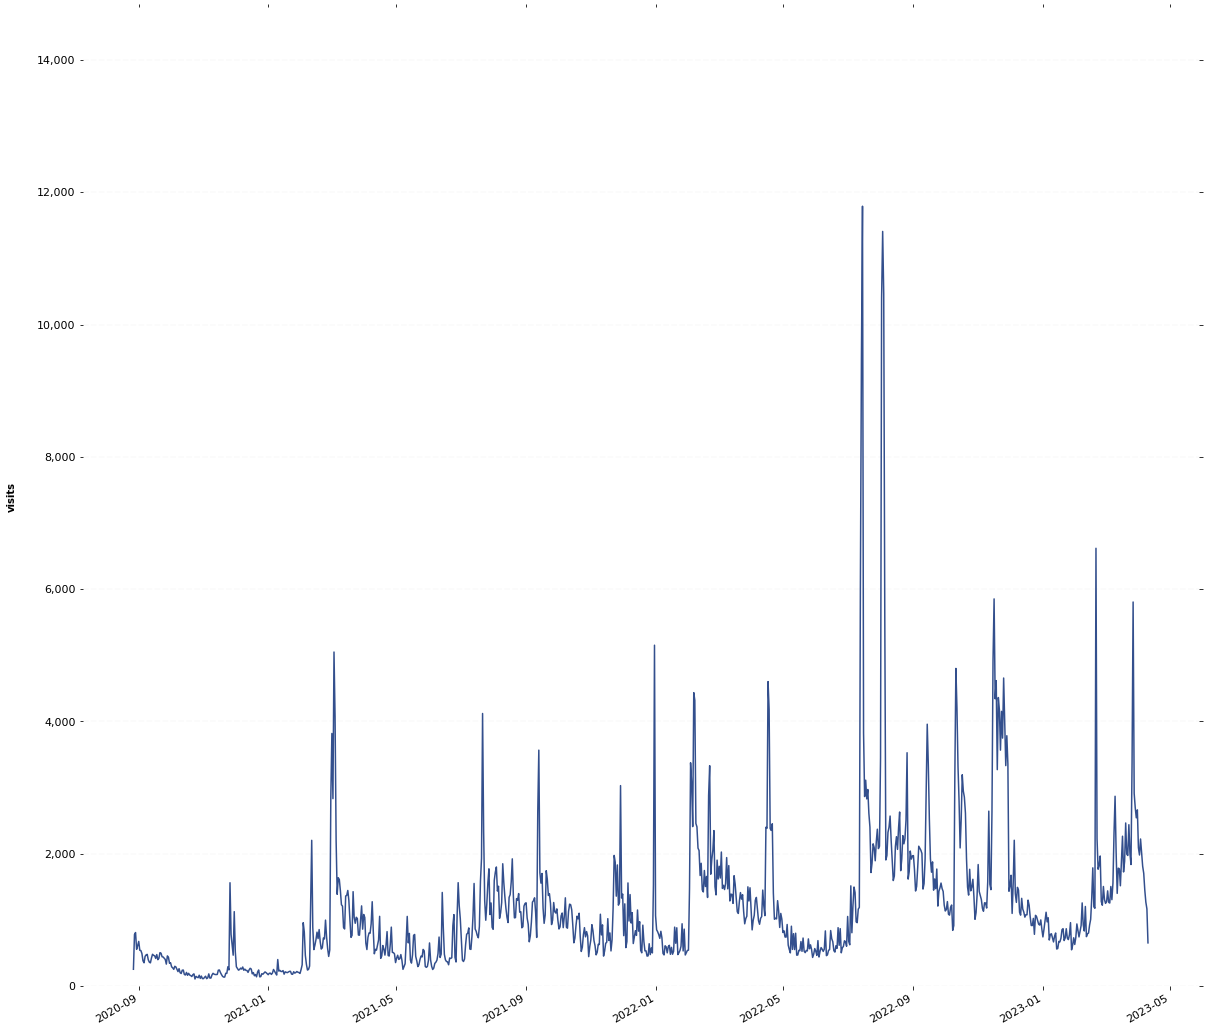

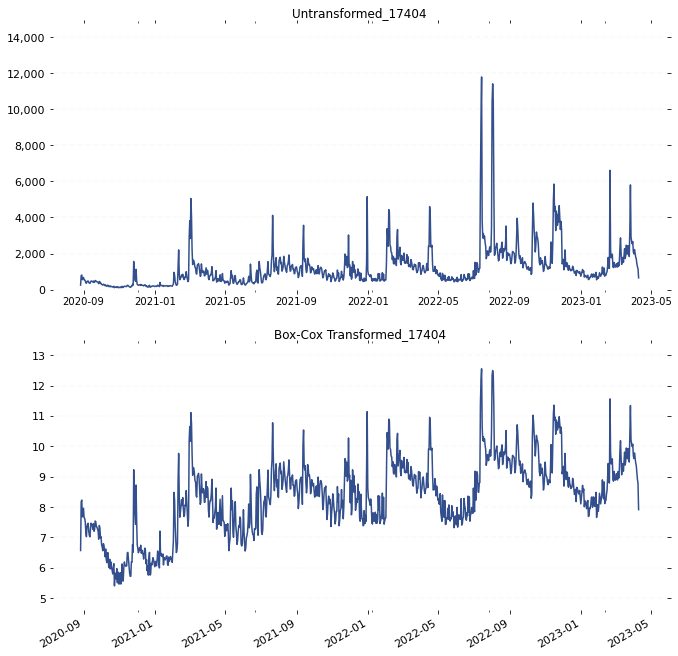

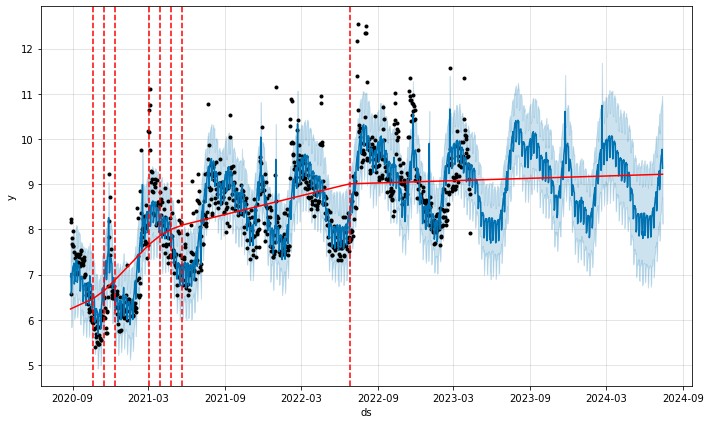

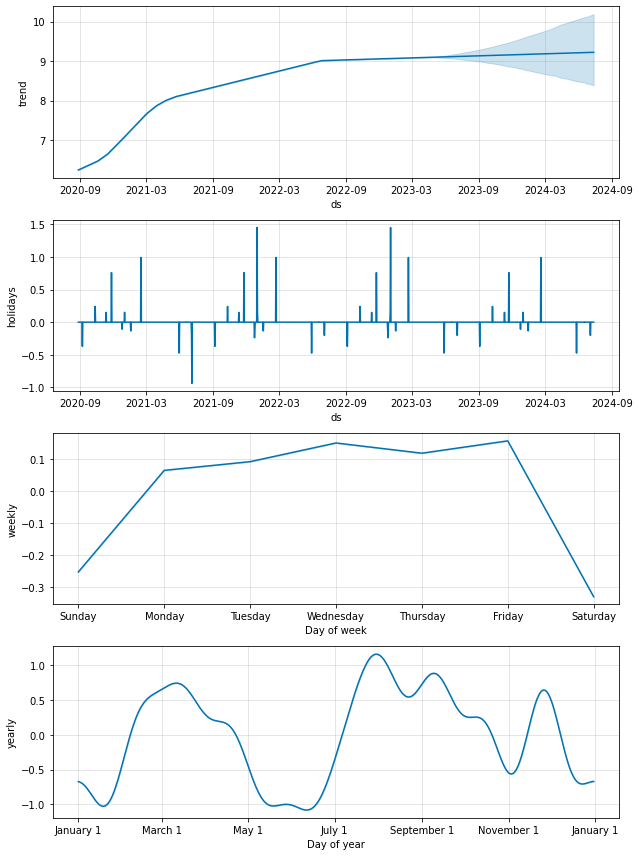

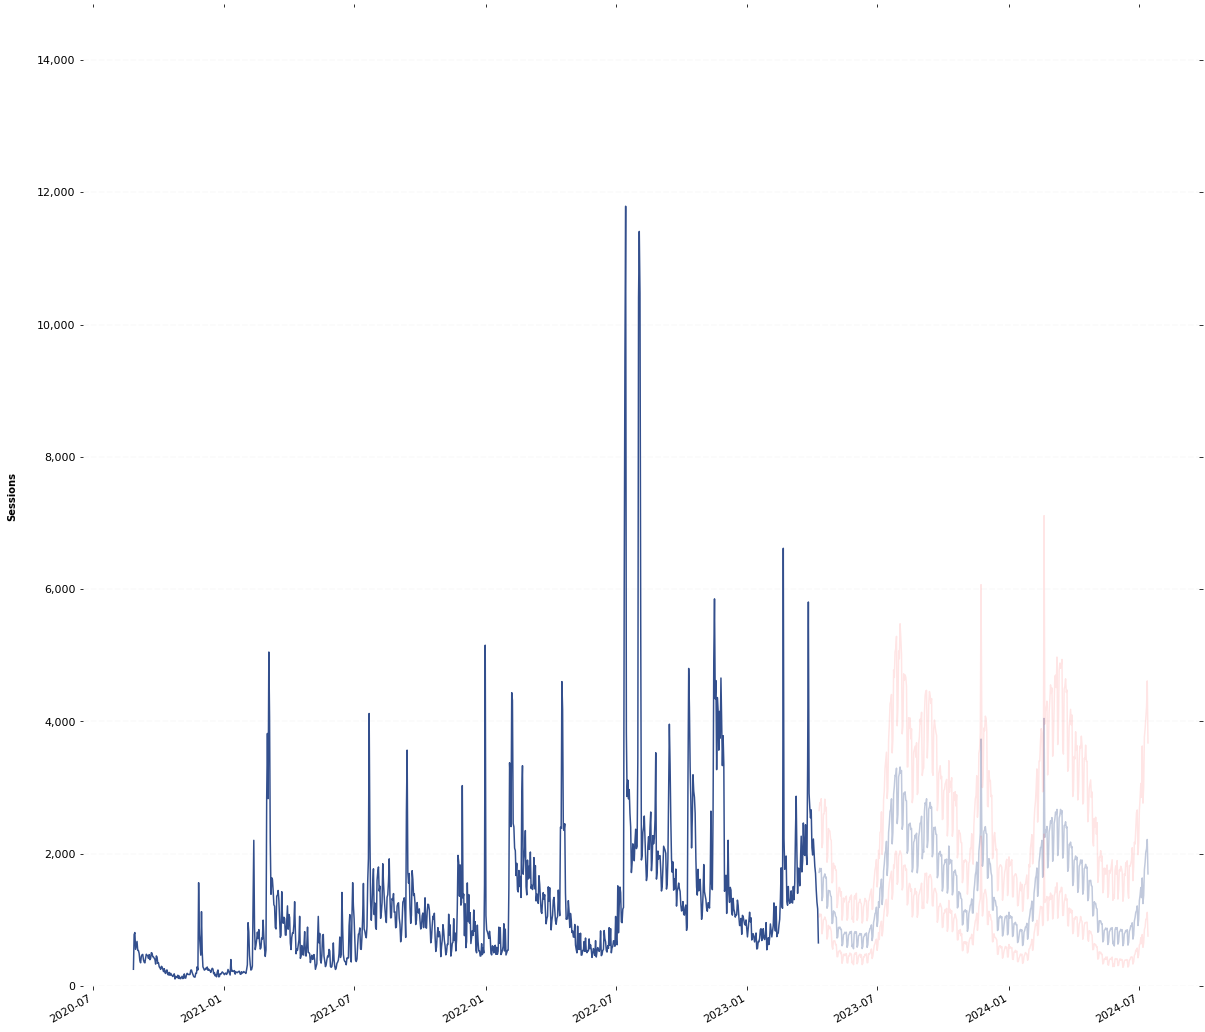

In [92]:
dd=[]

df=d[d.id==13843]

df['date'] = df['date'].astype('datetime64[ns]')
df =df.set_index('date')
df.info()


# Apply Box-Cox Transform to value column
df['y'], lam = boxcox(df['visits'])
dd.append(df)
# Print lambda value
print('Lambda: {}'.format(lam))
# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# Remove x-axis label
ax.set_xlabel('')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Annotate
# x_line_annotation = dt.datetime(2017, 5, 1) 
# x_text_annotation = dt.datetime(2017, 5, 5)
# ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
# ax.text(x=x_text_annotation, y=670000, s='Trend Changepoint', alpha=0.7, color='#334f8d')

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("visits", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0)

df=pd.concat(dd)



# Instantiate Prophet object
# m = fbprophet.Prophet(interval_width=.95)
m = prophet.Prophet(interval_width=.8 ,
#                         holidays=holidays,
#                         changepoint_prior_scale=0.075,
                        changepoint_range=.7)

m.add_country_holidays(country_name='US')

# Call fit method on Prophet object and pass in prepared dataframe. This is where model fitting is performed
m.fit(df)

# Create a dataframe with ds extending the chosen number of periods into the future
future = m.make_future_dataframe(periods=460)

# Create the forecast
forecast = m.predict(future)

forecast.tail()



ax = df[['visits','y']].plot(color='#334f8d', subplots=True,
                                     sharex=True, fontsize=11, 
                                     legend=False, figsize=(11,12),
                                     title=[f'Untransformed_{17404}',f'Box-Cox Transformed_{17404}'])

for i, x in enumerate(ax):
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.spines['bottom'].set_visible(False)

    # Remove x-axis label
    x.set_xlabel('')

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Format y-axis ticks
    vals = x.get_yticks()
    x.set_yticklabels(['{:,}'.format(int(y)) for y in vals])

    # Draw horizontal axis lines
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    # Set y-axis limit
    if i == 0:
        x.set_ylim(bottom=0)
        
        

# m.plot(forecast);
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
m.plot_components(forecast);



# Apply inverse Box-Cox transform to specific columns
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]
forecast = forecast.set_index('ds')

forecast.head()

    

# Create figure and subplot
plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# Plot
df['visits'].plot(color='#334f8d', fontsize=11, zorder=2, ax=ax)
forecast['yhat'][forecast.index > df.index.max()].plot(color='#334f8d', alpha=0.3, fontsize=11, zorder=2, ax=ax)
forecast['yhat_lower'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)
forecast['yhat_upper'][forecast.index > df.index.max()].plot(color='red', alpha=0.1, fontsize=11, zorder=2, ax=ax)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis label
ax.set_xlabel('')

# Change the facecolor
# ax.set_facecolor('#f7f7f9')

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Get y-axis tick values
vals = ax.get_yticks()

# Draw horizontal axis lines
for val in vals:
    ax.axhline(y=val, linestyle='dashed', alpha=0.3, color='#eeeeee', zorder=1)

# Format y-axis label
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# Set y-axis label
ax.set_ylabel("Sessions", labelpad=20, weight='bold')

# Set y-axis limit
ylim = ax.set_ylim(bottom=0)
# xlim = ax.set_xlim(left=pd.to_datetime('2019-01-01'))

In [93]:
forecast[forecast.index > pd.to_datetime('2022-10-31')] 
# forecast[forecast.index > df.index.max()] 
forecast['month'] = forecast.index.month
forecast['year'] = forecast.index.year
f = forecast.groupby(by=['year','month']).sum().tail(27)
f.reset_index(inplace=True)
f = f[f['year']>=2023]
f=f.T
f= f.reindex(["year", "month", "yhat_upper",'yhat','yhat_lower'])
# f.to_csv('20221103_ForecastV2_FHFStore.csv')
# f[f['month']]
f['store'] =13843
# total.append(f)
f
# f = forecast[forecast.year==2022]
# # forecast.iloc[:30,:]
# f =f[f.month == 11]
# pd.set_option('display.max_columns', None)
# f.T
# f2 = forecast[forecast.year==2022]
# f2 =f2[f2.month>=11]
# f2.groupby(by='month')[['yhat_upper','yhat','yhat_lower']].sum().T

,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,store
year,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,13843
month,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,13843
yhat_upper,43637.170122,80176.456732,106997.687970,73534.698394,41609.732885,39214.924384,106429.832185,122743.435037,110182.049884,79217.907663,85028.377360,65664.992860,48884.192820,99895.106856,128817.728037,93877.983142,54864.655773,54958.485253,45038.522785,13843
yhat,26791.118086,50161.870027,66668.309575,45445.821609,25168.304751,24073.630715,66072.613832,76110.641879,67899.812488,48182.856820,50471.760180,38400.194492,27381.060327,55809.559867,69787.422542,48808.332470,26720.881450,25517.579488,21396.173973,13843
yhat_lower,16121.113910,30871.330253,41359.768476,28001.003774,15002.986973,14329.552629,40823.768477,46934.345222,41237.329213,28811.709491,29862.779836,22035.807482,15091.624017,31129.874921,37984.462146,25664.082209,13206.200167,12088.478922,10292.824202,13843


In [261]:
# pd.concat(total).to_csv('2022104_BrandedForecastedsessions.csv')

In [310]:
# stores['month']=pd.to_datetime(stores['Date']).dt.month
# stores['year']=pd.to_datetime(stores['Date']).dt.year

# x = stores.groupby(['id','year','month']).agg({'Sessions':'sum'})
# x.reset_index(inplace=True)

# hold= []
# a = x[x.id==7623]

# for i in list(a.year.unique()):
#     a[a.year==i]
# #     hold.append(a[a.year==i].T)
# #     hold.append(a[a.year==i].set_index(['month']).T)
#     b= a[a.year==i].set_index(['month']).T
#     b=b[b.index!='id']
#     b=b[b.index!='year']
#     b.index = [i]
#     b
#     hold.append(b)

# # a[a.year==i].set_index(['month']).T
# pd.concat(hold).to_csv('20221104_FL_HistoricalSessions.csv')


# hold= []
# a = x[x.id==17404]

# for i in list(a.year.unique()):
#     a[a.year==i]
# #     hold.append(a[a.year==i].T)
# #     hold.append(a[a.year==i].set_index(['month']).T)
#     b= a[a.year==i].set_index(['month']).T
#     b=b[b.index!='id']
#     b=b[b.index!='year']
#     b.index = [i]
#     b
#     hold.append(b)

# # a[a.year==i].set_index(['month']).T
# pd.concat(hold).to_csv('20221104_ME_HistoricalSessions.csv')



# hold= []
# a = x[x.id==12841]

# for i in list(a.year.unique()):
#     a[a.year==i]
# #     hold.append(a[a.year==i].T)
# #     hold.append(a[a.year==i].set_index(['month']).T)
#     b= a[a.year==i].set_index(['month']).T
#     b=b[b.index!='id']
#     b=b[b.index!='year']
#     b.index = [i]
#     b
#     hold.append(b)

# # a[a.year==i].set_index(['month']).T
# pd.concat(hold).to_csv('20221104_FHF_HistoricalSessions.csv')


# hold= []
# a = x[x.id==13843]

# for i in list(a.year.unique()):
#     a[a.year==i]
# #     hold.append(a[a.year==i].T)
# #     hold.append(a[a.year==i].set_index(['month']).T)
#     b= a[a.year==i].set_index(['month']).T
#     b=b[b.index!='id']
#     b=b[b.index!='year']
#     b.index = [i]
#     b
#     hold.append(b)
# # a[a.year==i].set_index(['month']).T
# pd.concat(hold).to_csv('20221104_PG_HistoricalSessions.csv')




# CVR and AOV Moving Avg By day Re-forecast


In [29]:
org = pd.read_excel('Input/20230414_22SessionsbyDayBybrand.xlsx',sheet_name=4)

fl = pd.read_excel('Input/20230414_22SessionsbyDayBybrand.xlsx',sheet_name=0)
me = pd.read_excel('Input/20230414_22SessionsbyDayBybrand.xlsx',sheet_name=1)
fhf = pd.read_excel('Input/20230414_22SessionsbyDayBybrand.xlsx',sheet_name=2)
pg = pd.read_excel('Input/20230414_22SessionsbyDayBybrand.xlsx',sheet_name=3)



# /org['SMA_3'] = org.iloc[:,1].rolling(window=3).mean()


dfs = [org,fl,me,fhf,pg]
windows = [3,6,10,20]
for i in dfs: 
    i['CVR'] = i['Orders']/i['Sessions']
    i['AOV'] = i['Discounted Sales']/i['Orders']
    for x in windows: 
        i[f'SMA_CVR_{x}'] = i.loc[:,'CVR'].rolling(window=x).mean()
                
for i in dfs: 
    for x in windows: 
        i[f'SMA_AOV_{x}'] = i.loc[:,'AOV'].rolling(window=x).mean()

In [30]:
org.to_csv('Output/20230414_SMA_for_org.csv')
fl.to_csv('Output/20230414_SMA_for_fl.csv')
me.to_csv('Output/20230414_SMA_for_me.csv')
pg.to_csv('Output/20230414_SMA_for_pg.csv')
fhf.to_csv('Output/20230414_SMA_for_fhf.csv')